### Libraries

In [38]:
#Data Manipulation
import pandas as pd
import numpy as np

#Plots
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

#Utilities
import warnings
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.utils import shuffle
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler

#Models
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')
parameters = {
    "dataset":{
        "path": "../olds/prueba_csv.csv",
        "trainingSize": .60,
        "validationSize": .2,
        "testSize": .2
    },
    "validation": {
        "n_splits" : 6
    }
}

In [39]:
def plotDatasetSplit(X_train_dates, X_val_dates, X_test_dates, y_train, y_val, y_test):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=X_train_dates, y=y_train, mode="lines", name="Train"))
    fig.add_trace(go.Scatter(x=X_val_dates, y=y_val, mode="lines", name="Validation"))
    fig.add_trace(go.Scatter(x=X_test_dates, y=y_test, mode="lines", name="Test"))
    fig.update_layout(
        title = "Dataset Partition",
        xaxis_title = "Date",
        yaxis_title ="Demand (kWh)",
        width = 1000,
        height = 400,
        margin = dict(l=30, r=20, t=35, b=60),
        legend = dict(
            orientation = "h",
            yanchor = "bottom",
            y = 1.05,
            xanchor = "right",
            x=1
        )
    )
    fig.show()

In [40]:
def plotPredictions(dates, y_pred, y_test):
    fig = go.Figure()
    trace1 = go.Scatter(x=dates, y=y_test, name="test", mode="lines")
    trace2 = go.Scatter(x=dates, y=y_pred, name="predictions", mode="lines")
    fig.add_trace(trace1)
    fig.add_trace(trace2)
    fig.update_layout(
        title="Real value vs Predicted in Test Data",
        xaxis_title="Date Time",
        yaxis_title="Demand",
        width=1020,
        height=450,
        margin = dict(l=70, r=20, t=55, b=20),
        legend = dict(
            orientation = "h",
            yanchor="top",
            y=1.1,
            xanchor="left",
            x=0.76
        )
    )
    fig.show()

In [41]:
def permutation_feature_importance(model, X_test, y_test, feature_names):
    quantile_transformer = QuantileTransformer(output_distribution='uniform', random_state=42) 
    y_pred = model.predict(X_test)

    #rmse_ref = root_mean_squared_error(y_test.flatten(), y_pred.flatten())
    mae_ref = mean_absolute_error(y_test, y_pred)

    feature_importance = np.zeros(X_test.shape[1])

    for i in tqdm(range(X_test.shape[1]), total=(X_test.shape[1])):
        #Make a Copy of the Test Subset and Permute its values
        X_test_permuted = X_test.copy()
        X_test_permuted[:, i] = shuffle(X_test_permuted[:, i])

        #Calculate the metrics
        y_pred_permuted = model.predict(X_test_permuted)

        #rmse_permuted = root_mean_squared_error(y_test.flatten(), y_pred_permuted.flatten())
        mae_permuted = mean_absolute_error(y_test, y_pred_permuted)

        #Calculate the difference in the metrics
        feature_importance[i] = mae_ref - mae_permuted
    
    #Normalize feature importances
    feature_importance /= feature_importance.sum()

    #Sort indexes
    sorted_indexes = feature_importance.argsort()[::-1]
    sorted_importances = feature_importance[sorted_indexes]
    sorted_importances_names = feature_names[sorted_indexes]

    #Bar Plot
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(sorted_importances)), sorted_importances, align='center')
    plt.yticks(range(len(sorted_importances)), sorted_importances_names)
    plt.xlabel('Relative Importance')
    plt.ylabel('Features')
    plt.title('Feature Permutation Importance')
    plt.show()

In [42]:
def addNLags(df, lags=1):
    lag_df= df.copy()
    for i in range(1, lags + 1):
        lag_df[f'lag_{i}'] = lag_df["Demand"].shift(i * 96).fillna(0)

    return lag_df.fillna(0)

In [43]:
def normalizeData(data):
    df = data.copy()
    scaler = MinMaxScaler()
    return scaler.fit_transform(df)

## Machine Learning Models

### Split Dataset

In [44]:
df = pd.read_csv(parameters["dataset"]["path"], index_col=None)
df["Date"] = pd.to_datetime(df["Date"])
dates = df["Date"]
dates = pd.to_datetime(dates)

df = addNLags(df, 5)
df = df.drop(columns=["Date"], axis=1)

y = df["Demand"]
X = df.drop(columns=["Demand"], axis=1)
col_names = list(X.columns)

trainingSize = int(parameters["dataset"]["trainingSize"] * df.shape[0])
validationSize = trainingSize + int(parameters["dataset"]["validationSize"] * df.shape[0])

X_train, y_train = X.loc[:trainingSize, :].copy(), y.loc[:trainingSize].copy()
X_val, y_val = X.loc[trainingSize:validationSize, :].copy(), y.loc[trainingSize:validationSize].copy()
X_test, y_test = X.loc[validationSize:, :].copy(), y.loc[validationSize:].copy()

X_train_dates = dates.loc[:trainingSize].copy()
X_val_dates = dates.loc[trainingSize:validationSize].copy()
X_test_dates = dates.loc[validationSize:].copy()
print(f"Total Lags: {len(df)}")
print(f"Training Size:{len(X_train)}")
print(f"Validation Size:{len(X_val)}")
print(f"Test Size: {len(X_test)}")
df.columns

Total Lags: 46753
Training Size:28052
Validation Size:9351
Test Size: 9352


Index(['pres', 'slp', 'wind_dir', 'wind_gust_spd', 'wind_spd', 'temp', 'rh',
       'dewpt', 'clouds', 'vis', 'precip', 'dhi', 'dni', 'ghi', 'solar_rad',
       'uv', 'elev_angle', 'az', 'Temp interna Modulo', 'Year', 'Month',
       'Hour', 'DayOfWeek', 'DayOfYear', 'Demand', 'Season', 'isWeekend',
       'Hour_sin', 'Hour_cos', 'DayOfWeek_sin', 'DayOfWeek_cos', 'Month_sin',
       'Month_cos', 'DayOfYear_sin', 'DayOfYear_cos', 'lag_1', 'lag_2',
       'lag_3', 'lag_4', 'lag_5', 'lag_3_rev', 'lag_5_rev', 'cluster',
       'isHoliday'],
      dtype='object')

In [45]:
plotDatasetSplit(X_train_dates, X_val_dates, X_test_dates, y_train, y_val, y_test)

### List of Models to Test

In [46]:
models, models_names = [], []

#Tree Models
for n in [1000]:
    LGBM = LGBMRegressor(boosting_type='gbdt', n_estimators=n, learning_rate=0.01, random_state=123, n_jobs=-1, verbose=0)
    XGB = XGBRegressor(n_estimators=n, random_state=123, learning_rate=0.01, max_depth=5)
    GBM = GradientBoostingRegressor(n_estimators=n, learning_rate=0.01, random_state=123)
    models.append(LGBM)
    models_names.append("LGBM_" + str(n))
    models.append(XGB)
    models_names.append("XGB_" + str(n))
    
for n in [3, 5, 15]:
    KNN = KNeighborsRegressor(n_neighbors=n, weights='uniform')
    models.append(KNN)
    models_names.append("KNNr_" + str(n) + "_" + 'uniform')

In [47]:
quant_df = df.copy()
quantile_transformer = QuantileTransformer(output_distribution='uniform', random_state=42) 
quant_df["Demand"] = quantile_transformer.fit_transform(quant_df["Demand"].values.reshape(-1, 1)).flatten() 

quant_df = addNLags(quant_df, 5)

quant_y = quant_df["Demand"]
quant_X = quant_df.drop(columns=["Demand"], axis=1)
col_names = list(quant_X.columns)

trainingSize = int(parameters["dataset"]["trainingSize"] * quant_df.shape[0])
validationSize = trainingSize + int(parameters["dataset"]["validationSize"] * quant_df.shape[0])

X_quant_train, y_quant_train = quant_X.loc[:trainingSize, :].copy(), quant_y.loc[:trainingSize].copy()
X_quant_val, y_quant_val = quant_X.loc[trainingSize:validationSize, :].copy(), quant_y.loc[trainingSize:validationSize].copy()
X_quant_test, y_quant_test = quant_X.loc[validationSize:, :].copy(), quant_y.loc[validationSize:].copy()
y_quant_test = quantile_transformer.inverse_transform(y_quant_test.values.reshape(-1, 1)).flatten()

X_train_dates = dates.loc[:trainingSize].copy()
X_val_dates = dates.loc[trainingSize:validationSize].copy()
X_test_dates = dates.loc[validationSize:].copy()
print(f"Total Lags: {len(quant_df)}")
print(f"Training Size:{len(X_quant_train)}")
print(f"Validation Size:{len(X_quant_val)}")
print(f"Test Size: {len(X_quant_test)}")
df.columns

Total Lags: 46753
Training Size:28052
Validation Size:9351
Test Size: 9352


Index(['pres', 'slp', 'wind_dir', 'wind_gust_spd', 'wind_spd', 'temp', 'rh',
       'dewpt', 'clouds', 'vis', 'precip', 'dhi', 'dni', 'ghi', 'solar_rad',
       'uv', 'elev_angle', 'az', 'Temp interna Modulo', 'Year', 'Month',
       'Hour', 'DayOfWeek', 'DayOfYear', 'Demand', 'Season', 'isWeekend',
       'Hour_sin', 'Hour_cos', 'DayOfWeek_sin', 'DayOfWeek_cos', 'Month_sin',
       'Month_cos', 'DayOfYear_sin', 'DayOfYear_cos', 'lag_1', 'lag_2',
       'lag_3', 'lag_4', 'lag_5', 'lag_3_rev', 'lag_5_rev', 'cluster',
       'isHoliday'],
      dtype='object')

### Quantile Transformation

In [55]:
def benchmarkQuantileTrans(models, models_names):
    results = pd.DataFrame(columns=["Model", "RMSE", "MAE", "RMSE_Quant", "MAE_Quant"])
    quant_models = models.copy()
    
    for model, quant_model, model_name in zip(models, quant_models, models_names):
        if "KNN" in model_name:
            X_train = normalizeData(X_train)
            X_test = normalizeData(X_test)
            print(X_train)
        #No transformation
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = root_mean_squared_error(y_test, y_pred)
        
    #Quantile Transformation
        quant_model.fit(X_quant_train, y_quant_train)
        y_quant_pred = model.predict(X_quant_test)
        y_quant_pred =quantile_transformer.inverse_transform(y_quant_pred.reshape(-1, 1)).flatten()
        mae_quant = mean_absolute_error(y_quant_test, y_quant_pred)
        rmse_quant = root_mean_squared_error(y_quant_test, y_quant_pred)
        results.loc[len(results.index)] = [model_name, rmse, mae, rmse_quant, mae_quant] 
        print(f"{model_name} - MAE: {mae} RMSE: {rmse} Quantile Transformation --> MAE: {mae_quant} RMSE: {rmse_quant}")
    return results
benchmark = benchmarkQuantileTrans(models, models_names)
benchmark = benchmark.to_markdown(index=False)

UnboundLocalError: cannot access local variable 'X_train' where it is not associated with a value

In [51]:
print(benchmark)

| Model           |    RMSE |     MAE |   RMSE_Quant |   MAE_Quant |
|:----------------|--------:|--------:|-------------:|------------:|
| LGBM_1000       | 3.46626 | 1.86516 |      3.50247 |     1.64343 |
| XGB_1000        | 3.5962  | 1.96378 |      3.7699  |     1.72394 |
| KNNr_3_uniform  | 4.4529  | 2.47586 |      4.29672 |     2.23328 |
| KNNr_5_uniform  | 4.12142 | 2.31187 |      4.17313 |     2.1302  |
| KNNr_15_uniform | 3.77193 | 2.17414 |      4.09679 |     2.04565 |


In [ ]:
df = pd.read_csv(parameters["dataset"]["path"], index_col=None)
df["Date"] = pd.to_datetime(df["Date"])
dates = df["Date"]
dates = pd.to_datetime(dates)
quantile_transformer = QuantileTransformer(output_distribution='uniform', random_state=42) 
df["Demand"] = quantile_transformer.fit_transform(df["Demand"].values.reshape(-1, 1)).flatten() 

df = addNLags(df, 5)
df = df.drop(columns=["Date"], axis=1)

y = df["Demand"]
X = df.drop(columns=["Demand"], axis=1)
col_names = list(X.columns)

trainingSize = int(parameters["dataset"]["trainingSize"] * df.shape[0])
validationSize = trainingSize + int(parameters["dataset"]["validationSize"] * df.shape[0])

X_train, y_train = X.loc[:trainingSize, :].copy(), y.loc[:trainingSize].copy()
X_val, y_val = X.loc[trainingSize:validationSize, :].copy(), y.loc[trainingSize:validationSize].copy()
X_test, y_test = X.loc[validationSize:, :].copy(), y.loc[validationSize:].copy()
y_test = quantile_transformer.inverse_transform(y_test.values.reshape(-1, 1)).flatten()

X_train_dates = dates.loc[:trainingSize].copy()
X_val_dates = dates.loc[trainingSize:validationSize].copy()
X_test_dates = dates.loc[validationSize:].copy()
print(f"Total Lags: {len(df)}")
print(f"Training Size:{len(X_train)}")
print(f"Validation Size:{len(X_val)}")
print(f"Test Size: {len(X_test)}")
df.columns

Total Lags: 46753
Training Size:28052
Validation Size:9351
Test Size: 9352


Index(['pres', 'slp', 'wind_dir', 'wind_gust_spd', 'wind_spd', 'temp', 'rh',
       'dewpt', 'clouds', 'vis', 'precip', 'dhi', 'dni', 'ghi', 'solar_rad',
       'uv', 'elev_angle', 'az', 'Temp interna Modulo', 'Year', 'Month',
       'Hour', 'DayOfWeek', 'DayOfYear', 'Demand', 'Season', 'isWeekend',
       'Hour_sin', 'Hour_cos', 'DayOfWeek_sin', 'DayOfWeek_cos', 'Month_sin',
       'Month_cos', 'DayOfYear_sin', 'DayOfYear_cos', 'lag_1', 'lag_2',
       'lag_3', 'lag_4', 'lag_5', 'isHoliday'],
      dtype='object')

### Walking Forward Validation

<div align="center">
    <img src="https://miro.medium.com/v2/resize:fit:1400/1*lmUY2pKwxu5kwA1II6yAbQ.png" width=600px></img>
</div>


 20%|██        | 1/5 [00:22<01:30, 22.54s/it]

Model: LGBM_1000 ===> Mean Test MAE: 1.791653225085878, RMSE: 3.7963355810333397


 40%|████      | 2/5 [00:49<01:14, 24.87s/it]

Model: XGB_1000 ===> Mean Test MAE: 1.7972517305438187, RMSE: 3.850410358020658


 60%|██████    | 3/5 [00:55<00:32, 16.29s/it]

Model: KNNr_10_uniform ===> Mean Test MAE: 2.3853948402995, RMSE: 4.627733866769394


 80%|████████  | 4/5 [01:00<00:11, 11.97s/it]

Model: KNNr_20_uniform ===> Mean Test MAE: 1.9885736959807974, RMSE: 4.00211387166262


100%|██████████| 5/5 [01:06<00:00, 13.35s/it]

Model: KNNr_30_uniform ===> Mean Test MAE: 1.9482588727321388, RMSE: 3.9756360208551147


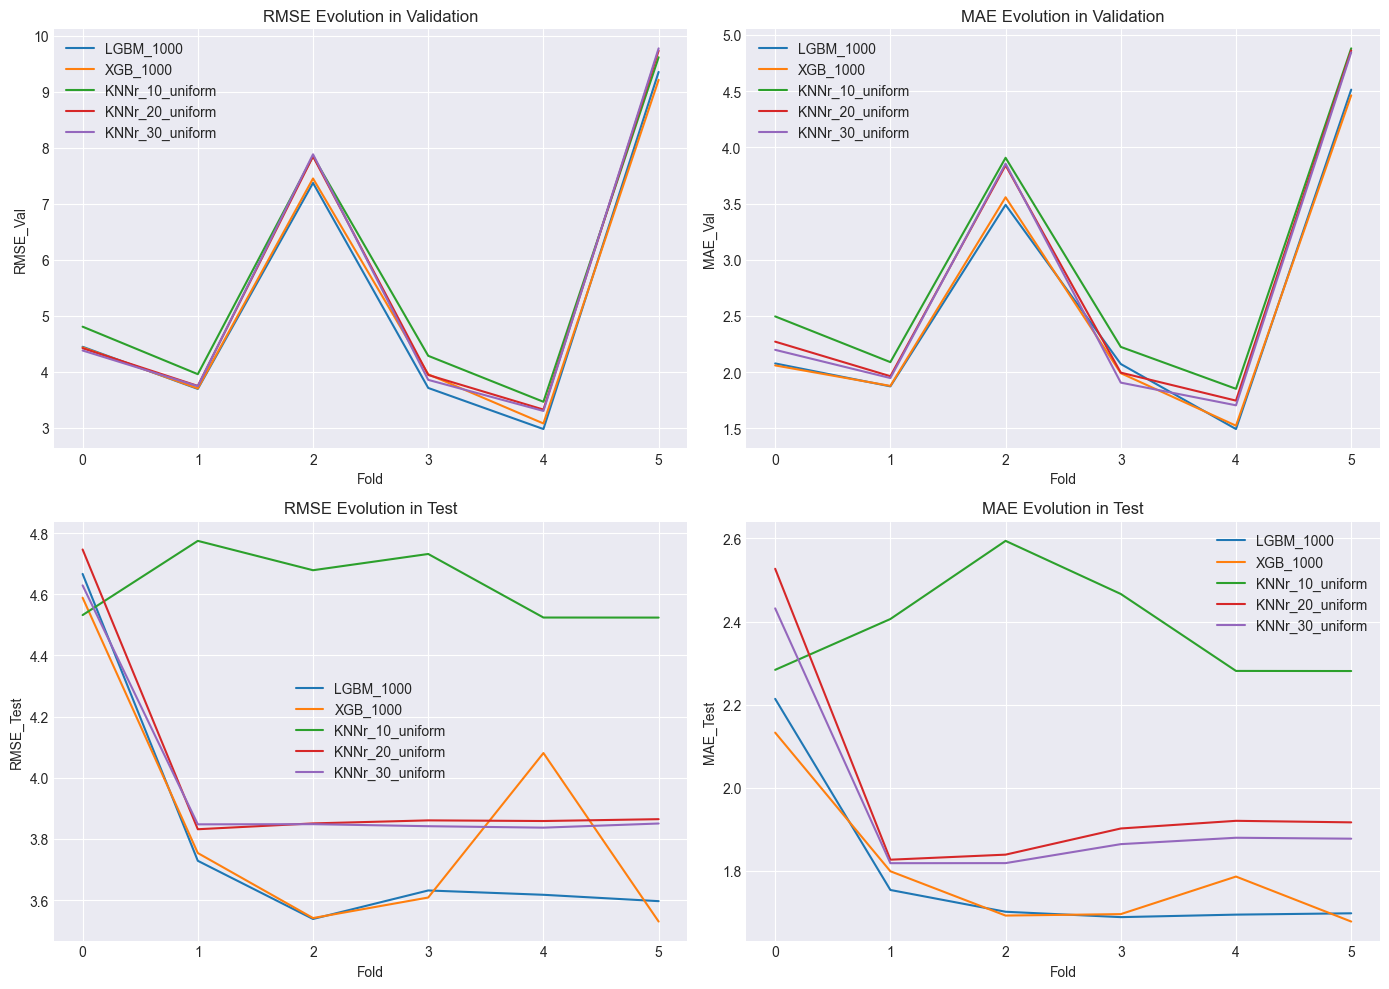

In [ ]:
def walkForwardValidation(X, y, X_test, y_test, models, models_names, params, plot=False, fixed_train=False):
    n_splits = params['validation']['n_splits']
    results = pd.DataFrame(columns=["Model", "RMSE_Test", "RMSE_Val", "MAE_Test", "MAE_Val","Mean_MRSE_Test", "Mean_MAE_Test", "Mean_RMSE_Val", "Mean_MAE_Val"])

    for model, model_name in tqdm(zip(models, models_names), total=len(models)):
        X_test2 = X_test.copy()
        X2 = X.copy()
        if fixed_train:
            tscv = TimeSeriesSplit(n_splits=n_splits, max_train_size=X.shape[0] // n_splits)
        else:
            tscv = TimeSeriesSplit(n_splits=n_splits)
        rmse_test, rmse_val, mae_test, mae_val = [], [], [], []
        for i, (train_index, eval_index) in enumerate(tscv.split(X2)):
            X_train, X_val = X2[train_index], X2[eval_index]
            y_train, y_val = y[train_index], y[eval_index]
            if "KNN" in model_name:
                X_train = normalizeData(X_train)
                X_val = normalizeData(X_val)
                X_test = normalizeData(X_test)
            model.fit(X=X_train, y=y_train)

            #Validation Scores
            y_pred_val = model.predict(X_val)
            y_pred_val = quantile_transformer.inverse_transform(y_pred_val.reshape(-1, 1)).flatten()
            y_val = quantile_transformer.inverse_transform(y_val.reshape(-1, 1)).flatten()

            mae_val.append(mean_absolute_error(y_val, y_pred_val))
            rmse_val.append(root_mean_squared_error(y_val, y_pred_val))
            
            #Test Scores
            y_pred_test = model.predict(X_test2)
            y_pred_test =quantile_transformer.inverse_transform(y_pred_test.reshape(-1, 1)).flatten()
            mae_test.append(mean_absolute_error(y_test, y_pred_test))
            rmse_test.append(root_mean_squared_error(y_test, y_pred_test))
            
        print(f"Model: {model_name} ===> Mean Test MAE: {np.mean(mae_test)}, RMSE: {np.mean(rmse_test)}")
        results.loc[len(results.index)] = [model_name, rmse_test, rmse_val, mae_test, mae_val, np.mean(rmse_test), np.mean(mae_test), np.mean(rmse_val), np.mean(mae_val)] 
    
    #Plots
    if plot:
        titles = ["RMSE Evolution in Validation", "MAE Evolution in Validation", "RMSE Evolution in Test", "MAE Evolution in Test"]
        metric_names = ["RMSE_Val", "MAE_Val", "RMSE_Test", "MAE_Test"]
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
        for i in range(4):
            metric_name = metric_names[i]
            title = titles[i]
            row = i // 2
            col = i % 2
            ax = axes[row, col]
            for index, row in results.iterrows():
                model_name = row["Model"]
                metric_values = row[metric_name]
                ax.plot(metric_values, label=model_name)

            ax.set_title(title)
            ax.set_xlabel("Fold")
            ax.set_ylabel(metric_name)
            ax.legend()
            ax.grid(True)
        if fixed_train:
            plt.savefig('../results/Sliding_Window_Validation_plot.png')
        else:
            plt.savefig('../results/Walking_Forward_Validation_plot.png')
        plt.tight_layout()
        plt.show()
    return results

results = walkForwardValidation(pd.concat([X_train, X_val], axis=0).to_numpy(), pd.concat([y_train, y_val], axis=0).to_numpy(), X_test, y_test, models, models_names, parameters, plot=True, fixed_train=False)
results.to_csv("../data/Processed_Data/Walking_Forward_Validation.csv", index=None)

### Sliding Window Validation

<div align="center">
    <img src="https://miro.medium.com/v2/resize:fit:1400/1*M3WnQy2H4GFtTctSgvQ48g.png" width=600px>
</div>

In [ ]:
results = walkForwardValidation(pd.concat([X_train, X_val], axis=0).to_numpy(), pd.concat([y_train, y_val], axis=0).to_numpy(), X_test, y_test, models, models_names, parameters, plot=True, fixed_train=True)
results.to_csv("../data/Processed_Data/Sliding_Window_Validation.csv", index=None)

  0%|          | 0/5 [00:17<?, ?it/s]


KeyboardInterrupt: 

### Grid Search (XGBOOST)

In [ ]:
paramsXGB = {
    'max_depth': [7, 8],
    'learning_rate': [0.005, 0.003],
    'gamma': [7, 8, 9],
    'colsample_bytree' : [0.7, 0.9, 1],
    'colsample_bynode': [ 0.7, 0.9, 1],
    'n_estimators': [1300]
}

def gridSearchXGB(params):
    best_mae = float('inf')
    config = {}
    for param in tqdm(ParameterGrid(params), total=len(list(ParameterGrid(params)))):
        max_depth = param.get('max_depth')
        n_estimators = param.get('n_estimators')
        lr = param.get('learning_rate')
        gamma = param.get('gamma')
        colsample_bytree = param.get('colsample_bytree')
        colsample_bynode = param.get('colsample_bynode')
        regressorXGBR = XGBRegressor(objective='reg:absoluteerror', n_estimators=n_estimators, learning_rate = lr, max_depth=max_depth, colsample_bytree = colsample_bytree, colsample_bynode = colsample_bynode, gamma=gamma, random_state=123, eval_metric='mae', early_stopping_rounds=100)

        regressorXGBR.fit(
            X = X_train,
            y = y_train,
            eval_set=[(X_val, y_val)],
            verbose=0
        )  
        y_pred = regressorXGBR.predict(X_test)
        y_pred = quantile_transformer.inverse_transform(y_pred.reshape(-1, 1)).flatten()
        mae = mean_absolute_error(y_test, y_pred)
        if mae < best_mae: 
            best_mae = mae
            config = param
        print(f"MAE: {mae}, n_Estimators: {n_estimators}, Learning_rate: {lr}, Max_depth: {max_depth}, Gamma: {gamma}, Col_Sample_By_Tree: {colsample_bytree}, Col_Sample_By_Node: {colsample_bynode}")
    config["mae"] = best_mae
    return config

#gridSearchXGB(paramsXGB)

  1%|          | 1/108 [00:18<32:42, 18.34s/it]

MAE: 1.6003226896258274, n_Estimators: 1300, Learning_rate: 0.005, Max_depth: 7, Gamma: 7, Col_Sample_By_Tree: 0.7, Col_Sample_By_Node: 0.7


  1%|          | 1/108 [00:29<52:34, 29.48s/it]


KeyboardInterrupt: 

### Grid Search (LightGBM)

In [ ]:
params = {
    'num_leaves': [10, 20, 30, 40],
    'learning_rate': [0.05, 0.01, 0.005],
    'colsample_bytree' : [0.7, 0.9, 1],
    'n_estimators': [1200],
    'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100]
}

def gridSearchLGBM(params):
    best_mae = float('inf')
    config = {}
    for param in tqdm(ParameterGrid(params), total=len(list(ParameterGrid(params)))):
        n_estimators = param.get('n_estimators')
        num_leaves = param.get('num_leaves')
        lr = param.get('learning_rate')
        reg_alpha = param.get('reg_alpha')
        colsample_bytree = param.get('colsample_bytree')
        LGBMReg = LGBMRegressor(boosting_type='gbdt', n_estimators=n_estimators, learning_rate=lr, random_state=123, reg_alpha=reg_alpha, n_jobs=-1, verbose=-1, early_stopping_rounds=100, num_leaves=num_leaves) 
        LGBMReg.fit(
            X = X_train,
            y = y_train,
            eval_set=[(X_val, y_val)]
        )  
        y_pred = LGBMReg.predict(X_test)
        y_pred = quantile_transformer.inverse_transform(y_pred.reshape(-1, 1)).flatten()
        mae = mean_absolute_error(y_test, y_pred)
        if mae < best_mae: 
            best_mae = mae
            config = param
        print(f"MAE: {mae}, n_Estimators: {n_estimators}, Learning_rate: {lr}, Num_leaves: {num_leaves}, Col_Sample_By_Tree: {colsample_bytree}, reg_alpha: {reg_alpha}")
    config["mae"] = best_mae
    return config
#gridSearchLGBM(params)

### Feature Importance 

In [ ]:
regressorXGBR = XGBRegressor(objective='reg:absoluteerror', n_estimators=1400, learning_rate = 0.003, max_depth=7, colsample_bytree = 0.9, colsample_bynode = 0.9, gamma=7, random_state=123,  eval_metric='mae', early_stopping_rounds=100)
regressorXGBR.fit(
    X = X_train,
    y = y_train,
    eval_set=[(X_val, y_val)],
    verbose=0
)

y_pred = regressorXGBR.predict(X_test)
y_pred = quantile_transformer.inverse_transform(y_pred.reshape(-1, 1)).flatten()
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
print(f"MAE: {mae}, RMSE: {rmse}")

imp_df = pd.DataFrame(data=regressorXGBR.feature_importances_, index=regressorXGBR.feature_names_in_, columns=['importance'])
imp_df.sort_values(by=["importance"])

MAE: 1.6765491927438971, RMSE: 3.6708704365624714


,importance
wind_gust_spd,0.005794
vis,0.006012
wind_spd,0.006217
wind_dir,0.006691
Year,0.007126
rh,0.007268
pres,0.007904
slp,0.007947
lag_5,0.008080
dewpt,0.009799


100%|██████████| 40/40 [00:03<00:00, 10.51it/s]


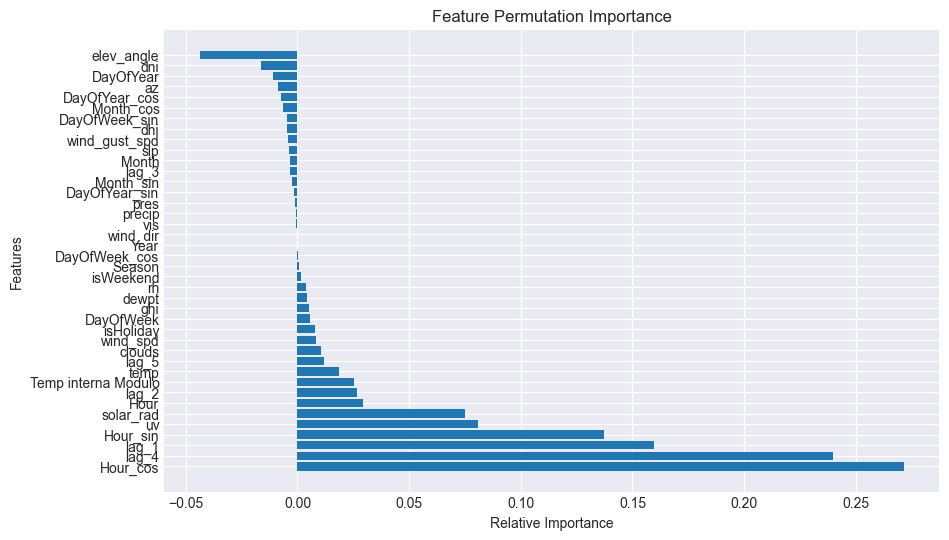

In [ ]:
permutation_feature_importance(regressorXGBR, X_test.to_numpy(), y_test, np.array(col_names))

### Plot Prediction Results

In [ ]:
plotPredictions(X_test_dates, y_pred, y_test)

In [ ]:
plotPredictions(X_test_dates[:96*24], y_pred[:96*24], y_test[:96*24])

In [ ]:
plotPredictions(X_test_dates[:96*7], y_pred[:96*7], y_test[:96*7])

In [ ]:
print(f"Test Demand Min: {np.min(y_test)} - Max: {np.max(y_test)}")
print(f"Predicted Demand Min: {np.min(y_pred)} - Max: {np.max(y_pred)}")

Test Demand Min: 2.0 - Max: 47.98799999999965
Predicted Demand Min: 2.0 - Max: 12.52646541595459


### Final Results

In [ ]:
regressorXGBR = XGBRegressor(objective='reg:absoluteerror', n_estimators=1400, learning_rate = 0.003, max_depth=7, colsample_bytree = 0.9, colsample_bynode = 0.9, gamma=7, random_state=123,  eval_metric='mae', early_stopping_rounds=100)
regressorXGBR2 = XGBRegressor(objective='reg:absoluteerror', n_estimators=1400, learning_rate = 0.003, max_depth=7, colsample_bytree = 0.9, colsample_bynode = 0.9, gamma=7, random_state=123,  eval_metric='mae')

#Model with Validation Set
regressorXGBR.fit(
    X = X_quant_train,
    y = y_quant_train,
    eval_set=[(X_quant_val, y_quant_val)],
    verbose=0
)

#Model without Validation Set
regressorXGBR2.fit(
    X = pd.concat([X_quant_train, X_quant_val], axis=0),
    y = np.concatenate([y_quant_train, y_quant_val], axis=0),
    verbose=0
)

y_pred = regressorXGBR.predict(X_test)
y_pred = quantile_transformer.inverse_transform(y_pred.reshape(-1, 1)).flatten()
print(f"With Validation set --> MAE: {mean_absolute_error(y_test, y_pred)}, RMSE: {root_mean_squared_error(y_test, y_pred)}")
y_pred = regressorXGBR2.predict(X_test)
y_pred = quantile_transformer.inverse_transform(y_pred.reshape(-1, 1)).flatten()
print(f"Without Validation set --> MAE: {mean_absolute_error(y_test, y_pred)}, RMSE: {root_mean_squared_error(y_test, y_pred)}")

With Validation set --> MAE: 1.6765491927438971, RMSE: 3.6708704365624714
Without Validation set --> MAE: 1.637709254338458, RMSE: 3.5340561179349805
